(applications-ctt)=
# Applicazioni della CTT

Le applicazioni della CTT discusse in questo capitolo sono presentate da @desjardins2018handbook. Tuttavia, i fondamenti teorici delle applicazioni qui considerate saranno spiegati nei capitoli successivi. In questo capitolo, ci limiteremo ad utilizzare le funzioni e i dati contenuti nel pacchetto `hemp`. 

In [1]:
source("_common.R")
suppressPackageStartupMessages(library("hemp"))
options(repr.plot.width=6, repr.plot.height=6)
set.seed(42)

## Attendibilità

Nell'esempio seguente, utilizziamo il set di dati SAPA per dimostrare come calcolare varie stime di coerenza interna in R. Ricordiamo che il data.frame SAPA (*Synthetic Aperture Personality Assessment*) è costituito da 1525 risposte a 16 item per la valutazione della personalità. Gli item misurano il ragionamento di base, la manipolazione di serie alfanumeriche, il ragionamento con matrici e la capacità di rotazione mentale.

Carichiamo i dati.

In [2]:
library("hemp")
data(SAPA)

Esaminiamo i dati mancanti.

In [3]:
num_miss(SAPA)

,num_miss,perc_miss
,<int>,<dbl>
reason.4,2,0.13
reason.16,1,0.07
reason.17,2,0.13
reason.19,2,0.13
letter.7,1,0.07
letter.33,2,0.13
letter.34,2,0.13
letter.58,0,0.00
matrix.45,2,0.13


Una semplice misura di coerenza interna è la affidabilità *split-half*. Una stima dell'affidabilità *split-half* può essere ottenuta dividendo un test in due parti equivalenti, calcolando i punteggi totali delle due parti e correlandoli. Ci sono molti modi per creare la suddivisione (ad esempio, selezionando gli item pari e quelli dispari, oppure in modo casuale, ecc.). Di seguito calcoliamo l'affidabilità *split-half* selezionando gli item pari e quelli dispari.

In [4]:
split_half(SAPA, type = "alternate")

[1] 0.758

In questo secondo caso, l'affidabilità *split-half* è calcolata selezionando due sottoinsiemi casuali di item della stessa numerosità.

In [5]:
set.seed(1)
split_half(SAPA, type = "random")

[1] 0.723

È noto che la stima dell'affidabilità split-half è distorta verso il basso (R. J. Cohen, Swerdlik e Sturman, 2013). La correzione Spearman-Brown può essere applicata per superare questo problema. Per fare ciò, basta passare l'argomento `sb = TRUE` alla funzione `split_half()`.

In [6]:
split_half(SAPA, type = "alternate", sb = TRUE)

[1] 0.8623436

Dopo aver applicato la correzione di Spearman-Brown, l'affidabilità split-half è ora stimata a 0.862, che è un po' più alta. 

Data la nostra attuale stima di affidabilità, possiamo anche determinare la lunghezza di un test per ottenere l'affidabilità desiderata. Possiamo farlo usando la funzione `test_length()` in `hemp`. Supponendo di volere un'affidabilità di 0.95, possiamo determinare di quanti item dovrebbe essere costituito il test. Nella chiamata a `test_length()`, specifichiamo `r_type = "split"` in modo che l'affidabilità attuale venga calcolata utilizzando l'affidabilità split-half con la correzione di Spearman-Brown. 

In [7]:
test_length(SAPA, r = .95, r_type = "split")

[1] 49

Se vogliamo un test con un'affidabilità di 0.95, dato che il nostro test attuale ha un'affidabilità di 0.862 basata su 16 item, avremmo bisogno di un test che consiste di almeno 49 item.

La misura più comune della consistenza interna è il coefficiente alfa (Cronbach, 1951). Il coefficiente alfa rappresenta la media di tutte le possibili correlazioni split-half. Può essere calcolato utilizzando la funzione `coef_alpha()` in `hemp`.

In [8]:
coef_alpha(SAPA)

[1] 0.841

Anche se le stime puntuali di affidabilità possono essere utili, è generalmente utile calcolare un intervallo di confidenza. Quando la dimensione del campione è piccola, le ipotesi dei modelli statistici non sono soddisfatte o la distribuzione campionaria di un parametro è sconosciuta, allora il bootstrap può essere utilizzato per costruire una distribuzione campionaria empirica, che possiamo quindi utilizzare per creare intervalli di confidenza (Efron & Tibshirani, 1986 ).

La nostra motivazione per l'introduzione del bootstrapping è che consente la creazione di intervalli di confidenza e incertezza indipendentemente dal parametro stimato. Pertanto, mentre illustriamo l'uso del bootstrap per il coefficiente alfa, questo può essere facilmente applicato per l'affidabilità split-half di cui sopra, la validità o le statistiche dell'analisi degli item presentati più avanti e in molti altri contesti.
Per eseguire il bootstrap per il coefficiente alfa, possiamo usare, ad esempio, il pacchetto `boot` (Canty & Ripley, 2017).

In [9]:
library(boot)

Dobbiamo creare una funzione da passare alla funzione `boot`, che chiamiamo `alpha_fun()`. Questa funzione accetta due argomenti: un set di dati, chiamato `data`, e una matrice di indici, chiamata `row` Questi argomenti vengono quindi passati alla funzione `coef_alpha`. Ciò consentirà alla funzione `boot` di eseguire un campionamento con rimpiazzo delle righe di `data` e creare una distribuzione empirica per il coefficiente alfa.

In [10]:
alpha_fun <- function(data, row){
  coef_alpha(data[row, ])}

In [11]:
alpha_boot <- boot(SAPA, alpha_fun, R = 1e3)
alpha_boot


ORDINARY NONPARAMETRIC BOOTSTRAP


Call:
boot(data = SAPA, statistic = alpha_fun, R = 1000)


Bootstrap Statistics :
    original   bias    std. error
t1*    0.841 -0.00026 0.005432487

La figura seguente mostra un istogramma e un Q-Q plot della distribuzione empirica per il coefficiente alfa basato sui 1000 campioni.

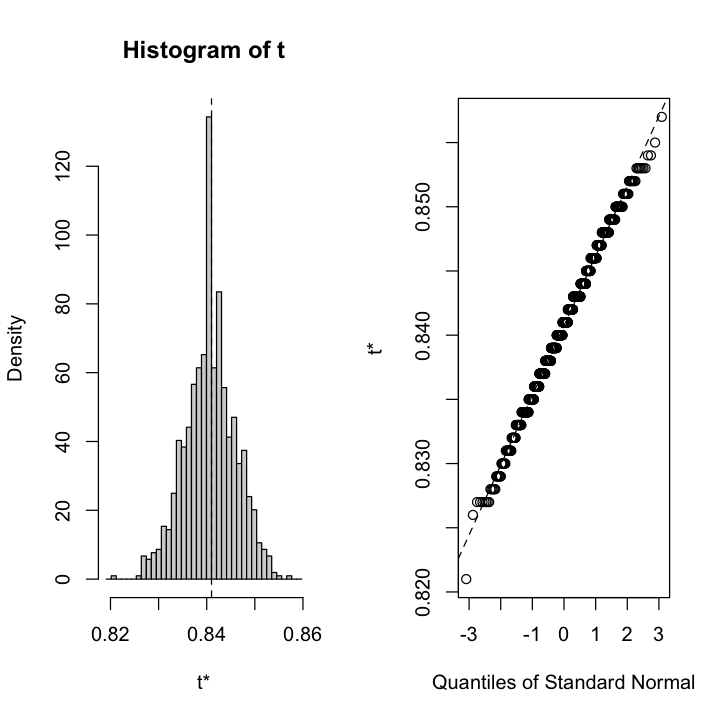

In [12]:
plot(alpha_boot)

Utilizziamo la funzione `boot.ci()` per calcolare gli intervalli di confidenza al 95% utilizzando gli intervalli `norm`, `basic` e `perc`. In breve, gli intervalli `basic` e `perc` fanno meno assunzioni rispetto agli intervalli `norm` (ovvero, nessuna assunzione di normalità asintotica). Se la distribuzione empirica si discosta dalla normalità, allora gli intervalli `basic` e `perc` sono una scelta migliore.

In [13]:
boot.ci(alpha_boot, type = c("norm", "basic", "perc"))

BOOTSTRAP CONFIDENCE INTERVAL CALCULATIONS
Based on 1000 bootstrap replicates

CALL : 
boot.ci(boot.out = alpha_boot, type = c("norm", "basic", "perc"))

Intervals : 
Level      Normal              Basic              Percentile     
95%   ( 0.8306,  0.8519 )   ( 0.8310,  0.8520 )   ( 0.8300,  0.8510 )  
Calculations and Intervals on Original Scale

Si può concludere che per la maggior parte degli scopi l'attendibilità sembra essere sufficientemente alta da non richiedere l'onere aggiuntivo per i rispondenti di aumentare la lunghezza dello strumento.

## Validità

La validità può essere esaminato in molti modi e quantificare l'evidenza di validità è abbastanza semplice con R. Una forma comune di evidenza di validità è l'opinione di un esperto. Le opinioni degli esperti possono aiutare a valutare l'adeguatezza del contenuto degli item, se lo strumento sta campionando adeguatamente tutte le dimensioni del dominio del costrutto e se gli item sono necessari per misurare il costrutto. Un modo per quantificare questo tipo di validità è con il *content validity ratio*, CVR (Lawshe, 1975). Il CVR è definito come:

$$
CVR = \frac{n_e - (N/2)}{N/2},
$$

dove $n_e$ è il numero di esperti che ritengono essenziale l'item e $N$ è il numero totale di esperti. Ad esempio, possiamo costruire uno strumento che interroghi i genitori sull'aggressività nei loro figli. Un item potrebbe chiedere: "Tuo figlio morde altri bambini?" Se chiediamo a 20 esperti se pensano che questo elemento sia essenziale per misurare l'aggressività nei bambini e 17 concordano che lo sia, allora il CVR può essere calcolato usando la funzione `cvr` di `hemp`:

In [14]:
cvr(N = 20, n_e = 17)

[1] 0.7

Scopriamo che il CVR è 0.70 per questo particolare item, ma non sappiamo se 0.70 sia abbastanza grande da mantenere l'item nello strumento. La tabella 1 in Lawshe (1975) fornisce valori soglia di CVR dato un determinato numero di esperti. Per 20 esperti, il CVR minimo è 0.42 e per cui potremmo concludere che gli esperti ritengono che questo item sia utile e potremmo mantenere questo item nel nostro strumento.

Altre forme di prova di validità valutano la misura in cui i punteggi del test si riferiscono a qualche criterio esterno (validità di criterio). Il supporto statistico per questa forma di validità può comportare il calcolo di correlazioni semplici o l'uso della regressione.

Esaminiamo il set di dati `interest`, un set di dati artificiale che contiene misure di personalità, di capacità cognitive e di interessi vocazionali. Per questi dati potremmo aspettarci che il test del vocabolario (`vocab`) sia correlato con valutazioni che misurano la comprensione della lettura (`reading`) e il completamento di frasi (`sent-comp`). Pertanto, possiamo utilizzare la funzione `cor` per calcolare la correlazione di Pearson tra queste variabili.

In [15]:
cor(interest[, c("vocab", "reading", "sentcomp")])

,vocab,reading,sentcomp
vocab,1.0000000,0.8030912,0.8132765
reading,0.8030912,1.0000000,0.7252155
sentcomp,0.8132765,0.7252155,1.0000000


La correlazione di Pearson tra `vocab` e `reading` è 0.803, mentre la correlazione tra `vocab` e `sentcomp` è 0.813. Ciò rappresenterebbe una prova di validità concorrente se i test di vocabolario fossero somministrati al momento della valutazione della lettura e del completamento della frase. Se il test del vocabolario precede i test di lettura e di completamento della frase, allora la correlazione di Pearson rappresenta una prova a sostegno della validità predittiva.

mmaginiamo di voler determinare se la comprensione della lettura può fornire informazioni aggiuntive sulla predisposizione di qualcuno a diventare un insegnante, oltre alla sola misura della personalità del dominio sociale. In altre parole, stiamo cercando di capire se la comprensione della lettura ha un valore predittivo incrementale rispetto alla misura della personalità.

Per fare ciò, useremo l'analisi di regressione, che ci permetterà di valutare se la comprensione della lettura è in grado di fornire informazioni aggiuntive e significative sulla predisposizione a diventare insegnanti. In particolare, utilizzeremo l'analisi di regressione per stabilire se la comprensione della lettura è in grado di predire l'interesse a diventare insegnanti, una volta tenuta in considerazione la misura della personalità del dominio sociale. Questo ci consentirà di valutare se la comprensione della lettura ha una validità incrementale nella predizione dell'interesse a diventare insegnanti, rispetto alla sola misura della personalità del dominio sociale.

In [16]:
mod_old <- lm(teacher ~ socdom, interest)
mod_new <- lm(teacher ~ socdom + reading, interest)

I modelli `mod_new` e `mod_old` sono nidificati, il che significa che `mod_new` include le stesse variabili indipendenti e dipendenti di `mod_old`, ma aggiunge la variabile `reading`. Per valutare il contributo di `reading` rispetto a `socdom` nella previsione di `teacher`, possiamo confrontare i due modelli esaminando il cambiamento del valore R-quadrato (R2).

Per fare ciò, possiamo utilizzare la funzione `anova` in R per confrontare statisticamente i due modelli. Questo test ci dirà se la variazione di R2 tra i due modelli è statisticamente significativa (cioè, se R2 > 0). Se la variazione di R2 risulta essere statisticamente significativa, allora possiamo affermare che la variabile `reading` spiega una quota aggiuntiva di varianza nella variabile dipendente `teacher`, al di là di ciò che viene spiegato dalla variabile `socdom`, laddove questo incremento non può essere attribuito al caso soltanto. In altre parole, `reading` aggiunge un valore predittivo incrementale nella previsione dell'interesse a diventare insegnanti, rispetto alla sola misura della personalità del dominio sociale `socdom`.

In [17]:
summary(mod_new)$r.squared - summary(mod_old)$r.squared
anova(mod_old, mod_new)

[1] 0.09125979

,Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,248,244.9772,NA,NA,NA,NA
2,247,221.0262,1,23.95093,26.7655,4.753606e-07


Dall'output sopra, vediamo che la valutazione della comprensione della lettura ha una validità incrementale oltre la sola misura di dominanza sociale (p <.001) e che spiega circa il 9% in più di variabilità nell'interesse per la professione di insegnante.

In [18]:
summary(mod_old) |>
    print()


Call:
lm(formula = teacher ~ socdom, data = interest)

Residuals:
    Min      1Q  Median      3Q     Max 
-4.0679 -0.6690  0.0823  0.6271  2.6064 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) -0.03279    0.06318  -0.519    0.604    
socdom       0.26392    0.06276   4.205 3.64e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.9939 on 248 degrees of freedom
Multiple R-squared:  0.06657,	Adjusted R-squared:  0.0628 
F-statistic: 17.69 on 1 and 248 DF,  p-value: 3.641e-05



In [19]:
summary(mod_new) |>
    print()


Call:
lm(formula = teacher ~ socdom + reading, data = interest)

Residuals:
    Min      1Q  Median      3Q     Max 
-4.3686 -0.6218  0.0592  0.6590  2.3245 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) -0.07399    0.06066  -1.220    0.224    
socdom       0.25320    0.05977   4.237 3.21e-05 ***
reading      0.31329    0.06056   5.174 4.75e-07 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.946 on 247 degrees of freedom
Multiple R-squared:  0.1578,	Adjusted R-squared:  0.151 
F-statistic: 23.14 on 2 and 247 DF,  p-value: 6.124e-10

